In [1]:
import matplotlib.pyplot as plt
import numpy as np
import talib
from collections import defaultdict
from dataclasses import dataclass
from enum import IntEnum
from matplotlib.ticker import FuncFormatter
from pathlib import Path
from typing import Callable, Optional

In [11]:
@dataclass
class PriceRow:
    day: int
    timestamp: int
    product: str
    bid_prices: list[int]
    bid_volumes: list[int]
    ask_prices: list[int]
    ask_volumes: list[int]
    mid_price: float
    profit_loss: float

@dataclass
class TradeRow:
    timestamp: int
    buyer: str
    seller: str
    symbol: str
    currency: str
    price: float
    quantity: int

@dataclass
class DayData:
    round: int
    day: int
    prices: list[PriceRow]
    trades: list[TradeRow]

def get_column_values(columns: list[str], indices: list[str]) -> list[int]:
    values = []

    for index in indices:
        value = columns[index]
        if value != "":
            values.append(int(value))

    return values

def read_data(round: int) -> list[DayData]:
    days = []

    directory = Path.cwd().parent.parent / "data" / f"round{round}"
    files = sorted(list(directory.iterdir()))

    for prices_file in files:
        if not prices_file.name.startswith("prices_round_"):
            continue

        day = int(prices_file.stem.split("_")[-1])
        trades_file = next(file for file in files if file.name.endswith(f"_{day}_wn.csv"))

        prices = []
        price_lines = prices_file.read_text(encoding="utf-8").splitlines()
        for line in price_lines[1:]:
            columns = line.split(";")

            prices.append(PriceRow(
                day=int(columns[0]),
                timestamp=int(columns[1]),
                product=columns[2],
                bid_prices=get_column_values(columns, [3, 5, 7]),
                bid_volumes=get_column_values(columns, [4, 6, 8]),
                ask_prices=get_column_values(columns, [9, 11, 13]),
                ask_volumes=get_column_values(columns, [10, 12, 14]),
                mid_price=float(columns[15]),
                profit_loss=float(columns[16]),
            ))

        trades = []
        trade_lines = trades_file.read_text(encoding="utf-8").splitlines()
        for line in trade_lines[1:]:
            columns = line.split(";")

            trades.append(TradeRow(
                timestamp=int(columns[0]),
                buyer=columns[1],
                seller=columns[2],
                symbol=columns[3],
                currency=columns[4],
                price=float(columns[5]),
                quantity=int(columns[6]),
            ))

        days.append(DayData(round, day, prices, trades))

    return days

rounds = {round: read_data(round) for round in range(1, 5)}
data = rounds[4]

In [3]:
class SignalDirection(IntEnum):
    LONG = 0
    SHORT = 1

@dataclass
class Signal:
    direction: SignalDirection
    hold_for: int

class SignalGenerator:
    def __init__(self) -> None:
        self.history = []

    def run(self, row: PriceRow) -> Optional[Signal]:
        signal = self.act(row)
        self.history.append(row)
        return signal

    def act(self, row: PriceRow) -> Optional[Signal]:
        raise NotImplementedError()

def run_generator(days: list[DayData], generator_factory: Callable[[], SignalGenerator]) -> None:
    profits = defaultdict(int)
    winning_trades = defaultdict(int)
    losing_trades = defaultdict(int)

    active_signals = {}
    open_times = defaultdict(int)
    open_prices = defaultdict(int)

    for day in days:
        generators = defaultdict(generator_factory)

        for i, row in enumerate(day.prices):
            if row.product in active_signals:
                signal = active_signals[row.product]

                if i - open_times[row.product] >= signal.hold_for or row.timestamp == day.prices[-1].timestamp:
                    if signal.direction == SignalDirection.LONG:
                        profit = row.mid_price - open_prices[row.product]
                    else:
                        profit = open_prices[row.product] - row.mid_price

                    profits[row.product] += profit
                    if profit > 0:
                        winning_trades[row.product] += 1
                    else:
                        losing_trades[row.product] += 1

                    active_signals.pop(row.product)

            signal = generators[row.product].run(row)
            if signal is None or row.product in active_signals:
                continue

            active_signals[row.product] = signal
            open_times[row.product] = i
            open_prices[row.product] = row.mid_price

    for product in sorted(set(row.product for row in days[0].prices)):
        winners = winning_trades[product]
        losers = losing_trades[product]
        winners_relative = winners / (winners + losers) * 100 if winners + losers > 0 else 0

        print(f"{product}: {profits[product]:,.0f} profit, {winners:,.0f} winners ({winners_relative:,.2f}%), {losers:,.0f} losers")

class NullSignalGenerator(SignalGenerator):
    def act(self, row: PriceRow) -> Optional[Signal]:
        return Signal(SignalDirection.SHORT, 10)

run_generator(data, NullSignalGenerator)

BAGUETTE: -323 profit, 2,885 winners (45.91%), 3,399 losers
BANANAS: 123 profit, 2,913 winners (41.29%), 4,142 losers
BERRIES: 87 profit, 2,192 winners (33.31%), 4,388 losers
COCONUTS: 58 profit, 2,857 winners (39.84%), 4,314 losers
DIP: -83 profit, 2,803 winners (40.55%), 4,109 losers
DIVING_GEAR: -1,392 profit, 3,412 winners (47.90%), 3,711 losers
DOLPHIN_SIGHTINGS: -123 profit, 933 winners (13.94%), 5,758 losers
PEARLS: 4 profit, 2,479 winners (35.17%), 4,569 losers
PICNIC_BASKET: -480 profit, 3,032 winners (48.07%), 3,276 losers
PINA_COLADAS: 97 profit, 3,075 winners (44.69%), 3,805 losers
UKULELE: 570 profit, 3,330 winners (46.95%), 3,763 losers


In [4]:
class DirectionalSignalGenerator(SignalGenerator):
    def act(self, row: PriceRow) -> Optional[Signal]:
        if row.product == "PEARLS":
            return None

        if len(self.history) < 50:
            return None

        delta = row.mid_price - self.history[-50].mid_price

        if delta >= 20:
            return Signal(SignalDirection.SHORT, 50)
        elif delta <= -20:
            return Signal(SignalDirection.LONG, 50)

        return None

run_generator([data[0]], DirectionalSignalGenerator)

BAGUETTE: -11 profit, 266 winners (48.99%), 277 losers
BANANAS: 0 profit, 0 winners (0.00%), 0 losers
BERRIES: 0 profit, 0 winners (0.00%), 0 losers
COCONUTS: 1 profit, 1 winners (100.00%), 0 losers
DIP: -6 profit, 13 winners (36.11%), 23 losers
DIVING_GEAR: 412 profit, 757 winners (50.74%), 735 losers
DOLPHIN_SIGHTINGS: 0 profit, 0 winners (0.00%), 0 losers
PEARLS: 0 profit, 0 winners (0.00%), 0 losers
PICNIC_BASKET: -1,894 profit, 838 winners (48.02%), 907 losers
PINA_COLADAS: 3 profit, 236 winners (46.37%), 273 losers
UKULELE: -284 profit, 399 winners (45.76%), 473 losers


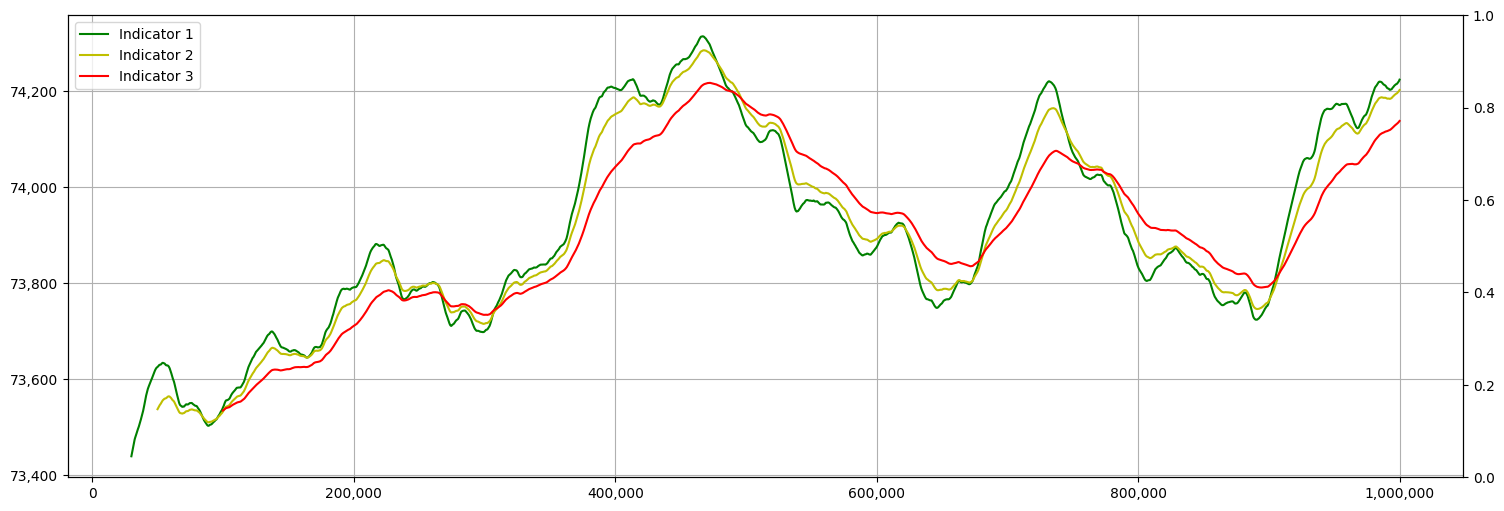

In [5]:
product = "PICNIC_BASKET"
rows = [row for row in data[0].prices if row.product == product]

count = 10000
x = np.array([row.timestamp for row in rows][:count])
y = np.array([row.mid_price for row in rows][:count])
y_volume = np.array([sum(row.bid_volumes) + sum(row.ask_volumes) for row in rows][:count])

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

formatter = FuncFormatter(lambda x, p: f"{x:,.0f}")
ax.get_xaxis().set_major_formatter(formatter)
ax.get_xaxis().set_minor_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
ax.get_yaxis().set_minor_formatter(formatter)

# ax.plot(x, y, label=product)

ax.plot(x, talib.EMA(y, 300), label="Indicator 1", color="g")
ax.plot(x, talib.EMA(y, 500), label="Indicator 2", color="y")
ax.plot(x, talib.EMA(y, 1000), label="Indicator 3", color="r")

ax.grid()
fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax.transAxes);

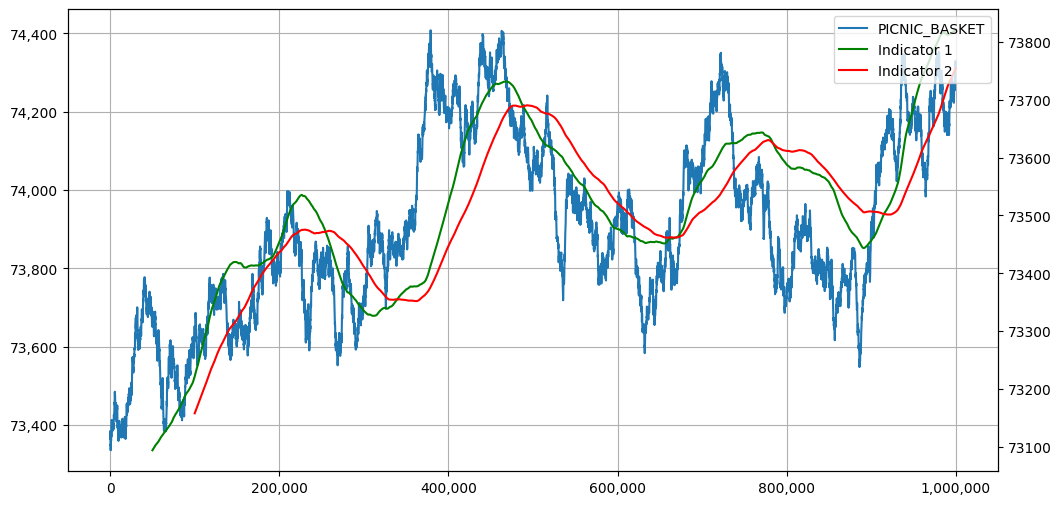

In [6]:
picnic_basket_rows = [row for row in data[0].prices if row.product == "PICNIC_BASKET"]
baguette_rows = [row for row in data[0].prices if row.product == "BAGUETTE"]
dip_rows = [row for row in data[0].prices if row.product == "DIP"]
ukulele_rows = [row for row in data[0].prices if row.product == "UKULELE"]

count = 10000
x = np.array([row.timestamp for row in picnic_basket_rows][:count])
y_picnic_basket = np.array([row.mid_price for row in picnic_basket_rows][:count])
y_baguette = np.array([row.mid_price for row in baguette_rows][:count])
y_dip = np.array([row.mid_price for row in dip_rows][:count])
y_ukulele = np.array([row.mid_price for row in ukulele_rows][:count])
y_underlying = 2 * y_baguette + 4 * y_dip + y_ukulele

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

formatter = FuncFormatter(lambda x, p: f"{x:,.0f}")
ax.get_xaxis().set_major_formatter(formatter)
ax.get_xaxis().set_minor_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
ax.get_yaxis().set_minor_formatter(formatter)

ax.plot(x, y_picnic_basket, label="PICNIC_BASKET")

ax2.plot(x, talib.MA(y_underlying, 500), label="Indicator 1", color="g")
ax2.plot(x, talib.MA(y_underlying, 1000), label="Indicator 2", color="r")

ax.grid()
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes);

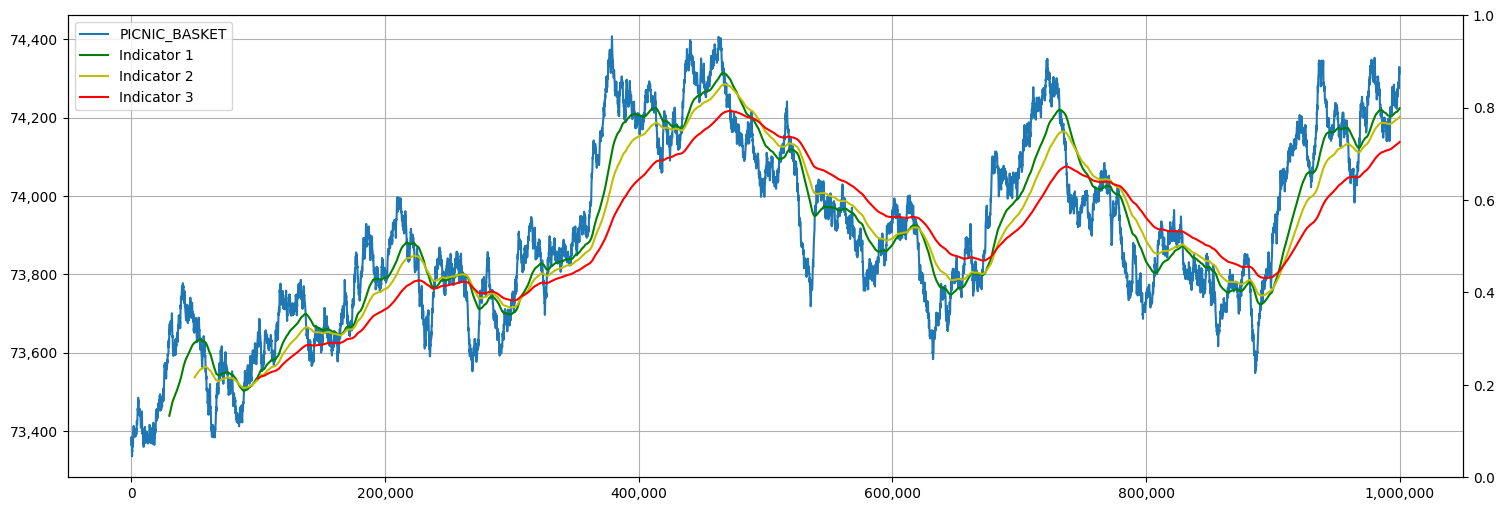

In [7]:
product = "PICNIC_BASKET"
rows = [row for row in data[0].prices if row.product == product]

count = 10000
x = np.array([row.timestamp for row in rows][:count])
y = np.array([row.mid_price for row in rows][:count])
y_volume = np.array([sum(row.bid_volumes) + sum(row.ask_volumes) for row in rows][:count])

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

formatter = FuncFormatter(lambda x, p: f"{x:,.0f}")
ax.get_xaxis().set_major_formatter(formatter)
ax.get_xaxis().set_minor_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
ax.get_yaxis().set_minor_formatter(formatter)

ax.plot(x, y, label=product)

ax.plot(x, talib.EMA(y, 300), label="Indicator 1", color="g")
ax.plot(x, talib.EMA(y, 500), label="Indicator 2", color="y")
ax.plot(x, talib.EMA(y, 1000), label="Indicator 3", color="r")

ax.grid()
fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax.transAxes);

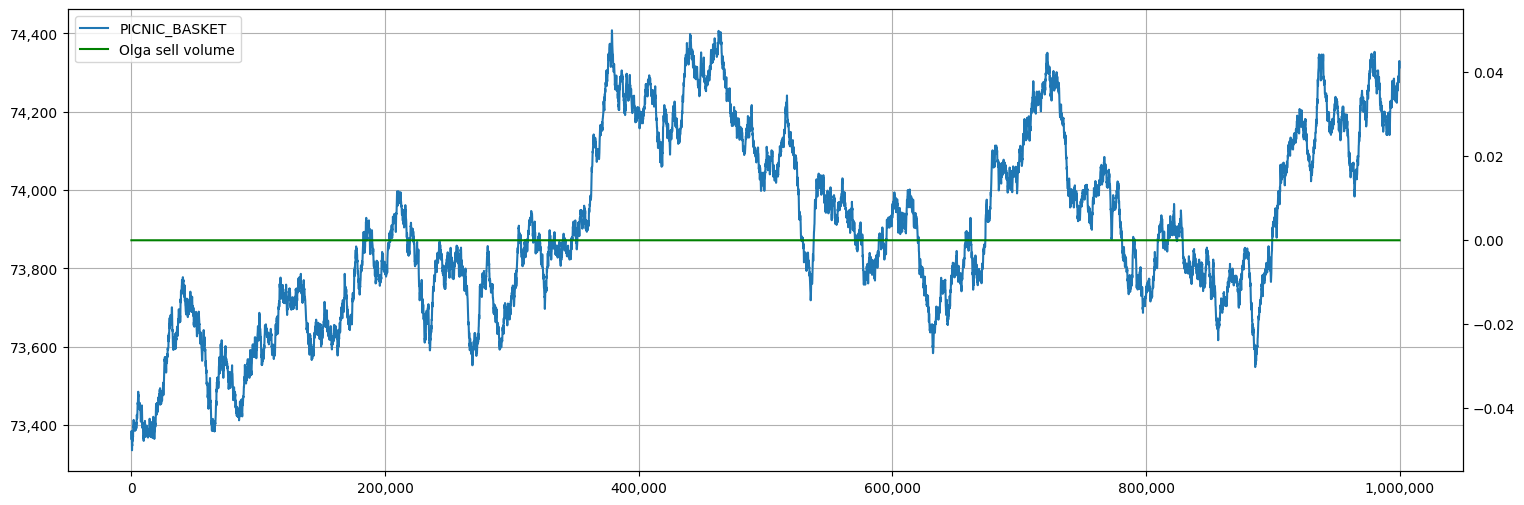

In [8]:
product = "PICNIC_BASKET"
bot = "Olga"
buy = False
day = 0

price_rows = [row for row in data[day].prices if row.product == product]

volume_by_timestamp = defaultdict(int)
for row in data[day].trades:
    if buy and row.buyer != bot:
        continue
    
    if not buy and row.seller != bot:
        continue

    volume_by_timestamp[row.timestamp] += row.quantity

count = 10000
x = np.array([row.timestamp for row in price_rows][:count])
y_price = np.array([row.mid_price for row in price_rows][:count])
y_trade_volume = np.array([volume_by_timestamp[timestamp] for timestamp in x])

fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

formatter = FuncFormatter(lambda x, p: f"{x:,.0f}")
ax1.get_xaxis().set_major_formatter(formatter)
ax1.get_xaxis().set_minor_formatter(formatter)
ax1.get_yaxis().set_major_formatter(formatter)
ax1.get_yaxis().set_minor_formatter(formatter)

ax1.plot(x, y_price, label=product)
ax2.plot(x, y_trade_volume, label=f"{bot} {'buy' if buy else 'sell'} volume", color="g")

ax1.grid()
fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax1.transAxes);

In [12]:
products = [
    "PEARLS",
    "BANANAS",
    "COCONUTS",
    "PINA_COLADAS",
    "DIVING_GEAR",
    "BERRIES",
    "BAGUETTE",
    "DIP",
    "UKULELE",
    "PICNIC_BASKET",
]

product_intros = {
    "PEARLS": 1,
    "BANANAS": 1,
    "COCONUTS": 2,
    "PINA_COLADAS": 2,
    "DIVING_GEAR": 3,
    "BERRIES": 3,
    "BAGUETTE": 4,
    "DIP": 4,
    "UKULELE": 4,
    "PICNIC_BASKET": 4,
}

days: dict[int, DayData] = {}
for round in range(2, 5):
    for day in rounds[round]:
        days[day.day] = day

bots = [
    "Peter",
    "Mitch",
    "Gary",
    "Penelope",
    "Omar",
    "Camilla",
    "Caesar",
    "Giulia",
    "Mabel",
    "Charlie",
    "Pablo",
    "Olivia",
    "Orson",
    "Casey",
    "George",
    "Mya",
    "Max",
    "Paris",
    "Gina",
    "Olga",
]

for bot in bots:
    for product in products:
        columns = [product]

        for day in sorted(days.keys()):
            if day < product_intros[product]:
                columns.append(0)
                continue

            prices_by_timestamp = {}
            for row in days[day].prices:
                if row.product == product:
                    prices_by_timestamp[row.timestamp] = row.mid_price
                pass